<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/GBM(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Agricultural Production Classification using Gradient Boosting Machine
Loading datasets...
Train dataset shape: (3584, 84)
Validation dataset shape: (768, 84)
Test dataset shape: (768, 84)

Creating production labels based on quantiles...
Production quantiles: 33% = 1030.00, 67% = 3977.46
Train label distribution:
production_label
medium    1211
low       1188
high      1185
Name: count, dtype: int64

Validation label distribution:
production_label
medium    261
high      257
low       250
Name: count, dtype: int64

Test label distribution:
production_label
medium    267
low       253
high      248
Name: count, dtype: int64

Preprocessing data...
Feature shape: 83 features
Preprocessing completed!

Training GBM model for 100 epochs...
Epoch 1: Train Acc = 0.8778, Val Acc = 0.8242
Epoch 10: Train Acc = 0.9280, Val Acc = 0.8737
Epoch 20: Train Acc = 0.9453, Val Acc = 0.8828
Epoch 30: Train Acc = 0.9621, Val Acc = 0.8958
Epoch 40: Train Acc = 0.9743, Val Acc = 0.8997
Epoch 50: Train Acc =

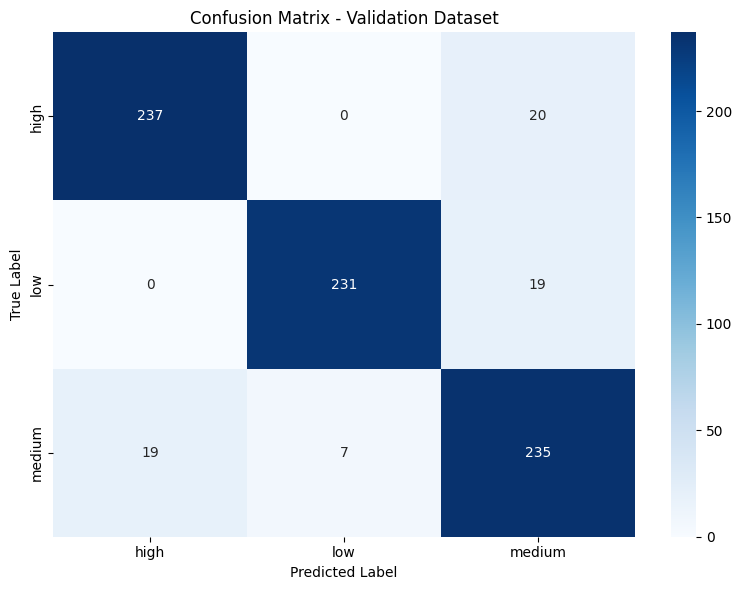

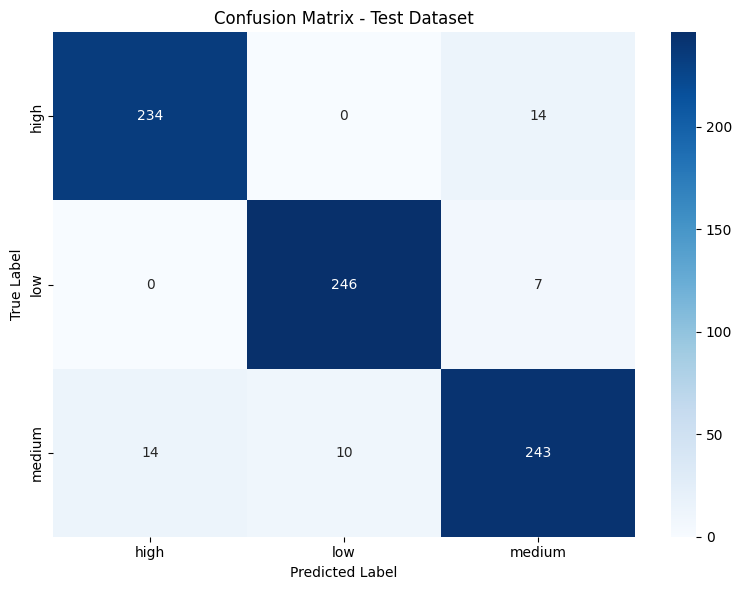


Generating Training Curves...


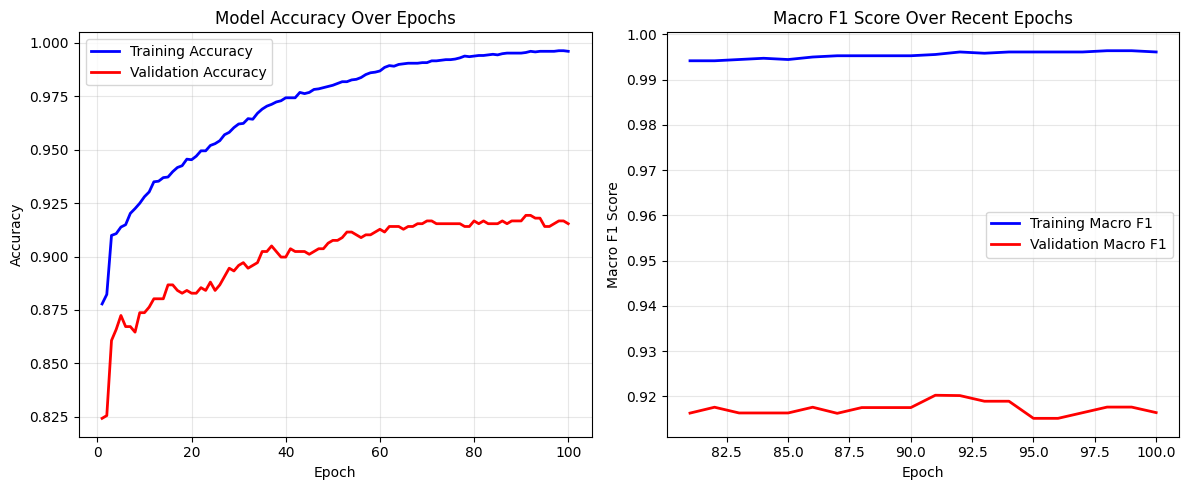


Analyzing Feature Importance...


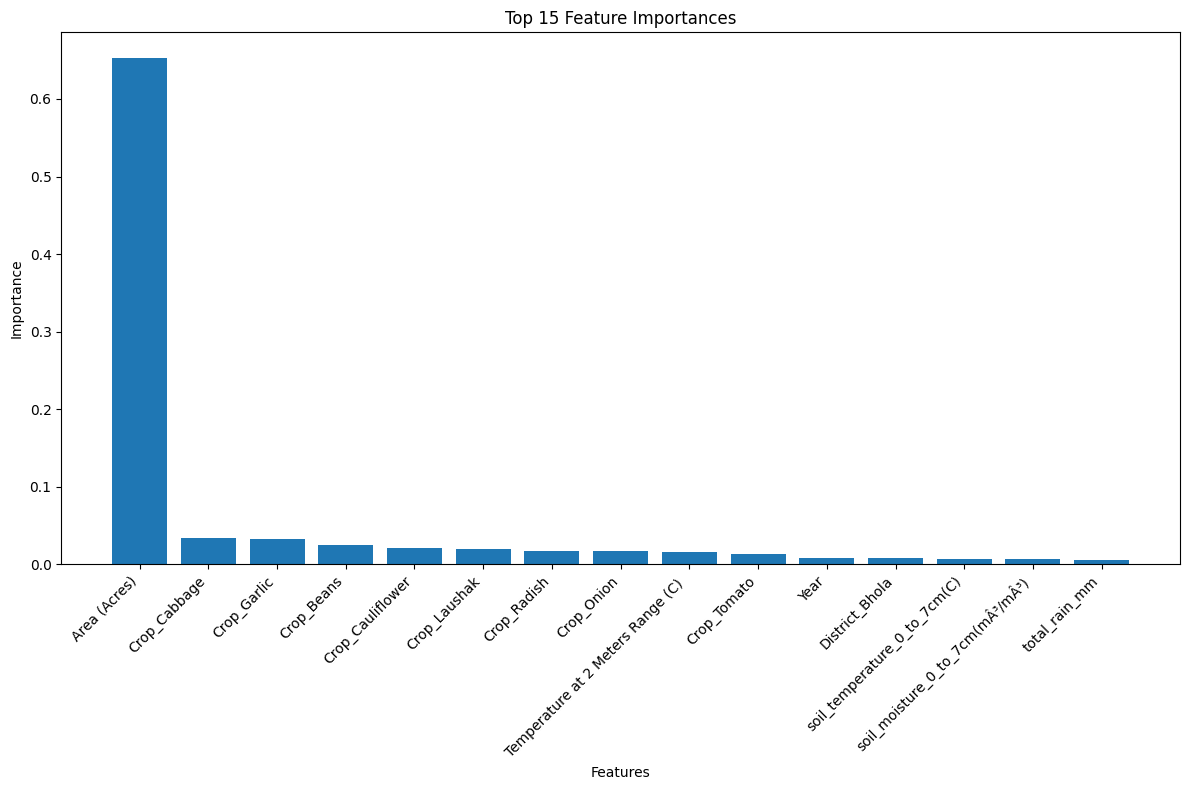


Top 15 Most Important Features:
1. Area (Acres): 0.6533
2. Crop_Cabbage: 0.0348
3. Crop_Garlic: 0.0335
4. Crop_Beans: 0.0247
5. Crop_Cauliflower: 0.0210
6. Crop_Laushak: 0.0197
7. Crop_Radish: 0.0169
8. Crop_Onion: 0.0169
9. Temperature at 2 Meters Range (C) : 0.0159
10. Crop_Tomato: 0.0134
11. Year: 0.0090
12. District_Bhola: 0.0085
13. soil_temperature_0_to_7cm(C): 0.0072
14. soil_moisture_0_to_7cm(mÂ³/mÂ³): 0.0066
15. total_rain_mm: 0.0060

FINAL SUMMARY
Validation Macro F1 Score: 0.9164
Test Macro F1 Score: 0.9418
Validation Accuracy: 0.9154
Test Accuracy: 0.9414

Validation Prediction Distribution:
medium    274
high      256
low       238
Name: count, dtype: int64

Test Prediction Distribution:
medium    264
low       256
high      248
Name: count, dtype: int64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support)
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class GBMProductionClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        """
        Initialize GBM classifier with specified parameters
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.train_scores = []
        self.val_scores = []
        self.quantiles = None

    def load_data(self, train_path, val_path, test_path):
        """
        Load training, validation, and test datasets
        """
        print("Loading datasets...")
        self.train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        self.val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        self.test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"Train dataset shape: {self.train_df.shape}")
        print(f"Validation dataset shape: {self.val_df.shape}")
        print(f"Test dataset shape: {self.test_df.shape}")

        return self.train_df, self.val_df, self.test_df

    def create_production_labels(self):
        """
        Create production labels based on quantiles (low, medium, high)
        """
        print("\nCreating production labels based on quantiles...")

        # Combine all production values to calculate quantiles
        all_production = pd.concat([
            self.train_df['Production (M.Ton)'],
            self.val_df['Production (M.Ton)'],
            self.test_df['Production (M.Ton)']
        ])

        # Calculate quantiles
        self.quantiles = {
            '33%': all_production.quantile(0.33),
            '67%': all_production.quantile(0.67)
        }

        print(f"Production quantiles: 33% = {self.quantiles['33%']:.2f}, 67% = {self.quantiles['67%']:.2f}")

        # Create labels for each dataset
        for df, name in [(self.train_df, 'train'), (self.val_df, 'validation'), (self.test_df, 'test')]:
            df['production_label'] = pd.cut(
                df['Production (M.Ton)'],
                bins=[-np.inf, self.quantiles['33%'], self.quantiles['67%'], np.inf],
                labels=['low', 'medium', 'high']
            )
            print(f"{name.capitalize()} label distribution:")
            print(df['production_label'].value_counts())
            print()

    def preprocess_data(self):
        """
        Preprocess the data: handle missing values, encode categorical variables
        """
        print("Preprocessing data...")

        # Drop the target column from features
        feature_cols = [col for col in self.train_df.columns if col not in ['Production (M.Ton)', 'production_label']]

        # Prepare features and targets
        self.X_train = self.train_df[feature_cols].copy()
        self.y_train = self.train_df['production_label'].copy()

        self.X_val = self.val_df[feature_cols].copy()
        self.y_val = self.val_df['production_label'].copy()

        self.X_test = self.test_df[feature_cols].copy()
        self.y_test = self.test_df['production_label'].copy()

        # Handle missing values
        for df in [self.X_train, self.X_val, self.X_test]:
            df.fillna(df.median(), inplace=True)

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Encode labels
        self.y_train_encoded = self.label_encoder.fit_transform(self.y_train)
        self.y_val_encoded = self.label_encoder.transform(self.y_val)
        self.y_test_encoded = self.label_encoder.transform(self.y_test)

        print(f"Feature shape: {self.X_train_scaled.shape[1]} features")
        print("Preprocessing completed!")

    def train_model_with_epochs(self, epochs=100):
        """
        Train GBM model with monitoring of training and validation performance
        """
        print(f"\nTraining GBM model for {epochs} epochs...")

        # Initialize model with warm start capability
        self.model = GradientBoostingClassifier(
            n_estimators=1,  # Start with 1 estimator
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            random_state=self.random_state,
            warm_start=True
        )

        self.train_scores = []
        self.val_scores = []

        # Training loop with epoch monitoring
        for epoch in range(1, epochs + 1):
            # Update number of estimators
            self.model.n_estimators = epoch

            # Fit the model
            self.model.fit(self.X_train_scaled, self.y_train_encoded)

            # Predict and calculate scores
            train_pred = self.model.predict(self.X_train_scaled)
            val_pred = self.model.predict(self.X_val_scaled)

            train_acc = accuracy_score(self.y_train_encoded, train_pred)
            val_acc = accuracy_score(self.y_val_encoded, val_pred)

            self.train_scores.append(train_acc)
            self.val_scores.append(val_acc)

            # Print progress every 10 epochs
            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        print("Training completed!")

    def evaluate_model(self, X, y_true, y_encoded, dataset_name):
        """
        Evaluate model performance and return metrics
        """
        y_pred = self.model.predict(X)

        # Calculate metrics
        accuracy = accuracy_score(y_encoded, y_pred)
        precision_macro = precision_score(y_encoded, y_pred, average='macro', zero_division=0)
        recall_macro = recall_score(y_encoded, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_encoded, y_pred, average='macro', zero_division=0)

        precision_weighted = precision_score(y_encoded, y_pred, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_encoded, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_encoded, y_pred, average='weighted', zero_division=0)

        # Detailed classification report
        class_names = self.label_encoder.classes_
        y_pred_labels = self.label_encoder.inverse_transform(y_pred)

        print(f"\n{dataset_name} Dataset Evaluation:")
        print("="*50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Macro): {precision_macro:.4f}")
        print(f"Recall (Macro): {recall_macro:.4f}")
        print(f"F1-Score (Macro): {f1_macro:.4f}")
        print(f"Precision (Weighted): {precision_weighted:.4f}")
        print(f"Recall (Weighted): {recall_weighted:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")

        print(f"\nDetailed Classification Report for {dataset_name}:")
        print(classification_report(y_true, y_pred_labels, target_names=class_names))

        return {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'f1_weighted': f1_weighted,
            'y_pred': y_pred,
            'y_pred_labels': y_pred_labels
        }

    def plot_confusion_matrix(self, y_true, y_pred, dataset_name):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        class_names = self.label_encoder.classes_

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {dataset_name} Dataset')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

    def plot_training_curves(self):
        """
        Plot training vs validation accuracy curves
        """
        epochs = range(1, len(self.train_scores) + 1)

        plt.figure(figsize=(12, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_scores, 'b-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, self.val_scores, 'r-', label='Validation Accuracy', linewidth=2)
        plt.title('Model Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Macro F1 Score tracking (calculate for last few epochs)
        plt.subplot(1, 2, 2)
        # Calculate F1 scores for recent epochs
        recent_epochs = epochs[-20:] if len(epochs) > 20 else epochs
        train_f1_scores = []
        val_f1_scores = []

        for epoch in recent_epochs:
            # Temporarily set model to specific epoch
            temp_model = GradientBoostingClassifier(
                n_estimators=epoch,
                learning_rate=self.learning_rate,
                max_depth=self.max_depth,
                random_state=self.random_state
            )
            temp_model.fit(self.X_train_scaled, self.y_train_encoded)

            train_pred = temp_model.predict(self.X_train_scaled)
            val_pred = temp_model.predict(self.X_val_scaled)

            train_f1 = f1_score(self.y_train_encoded, train_pred, average='macro')
            val_f1 = f1_score(self.y_val_encoded, val_pred, average='macro')

            train_f1_scores.append(train_f1)
            val_f1_scores.append(val_f1)

        plt.plot(recent_epochs, train_f1_scores, 'b-', label='Training Macro F1', linewidth=2)
        plt.plot(recent_epochs, val_f1_scores, 'r-', label='Validation Macro F1', linewidth=2)
        plt.title('Macro F1 Score Over Recent Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Macro F1 Score')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def get_feature_importance(self, top_n=15):
        """
        Get and plot feature importance
        """
        if self.model is None:
            print("Model not trained yet!")
            return

        feature_names = self.X_train.columns
        importances = self.model.feature_importances_

        # Sort features by importance
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importances')
        plt.bar(range(top_n), importances[indices[:top_n]])
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

        print(f"\nTop {top_n} Most Important Features:")
        for i in range(top_n):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

def main():
    """
    Main function to run the complete GBM classification pipeline
    """
    print("Agricultural Production Classification using Gradient Boosting Machine")
    print("="*70)

    # Initialize classifier
    gbm_classifier = GBMProductionClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )

    # Step 1: Load datasets
    try:
        train_df, val_df, test_df = gbm_classifier.load_data('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv', '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv', '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        print("Please ensure train.csv, validation.csv, and test.csv are in the current directory")
        return

    # Step 2: Create production labels based on quantiles
    gbm_classifier.create_production_labels()

    # Step 3: Preprocess data
    gbm_classifier.preprocess_data()

    # Step 4: Train model with epoch monitoring
    gbm_classifier.train_model_with_epochs(epochs=100)

    # Step 5: Evaluate on validation set
    print("\n" + "="*70)
    print("VALIDATION SET EVALUATION")
    print("="*70)

    val_metrics = gbm_classifier.evaluate_model(
        gbm_classifier.X_val_scaled,
        gbm_classifier.y_val,
        gbm_classifier.y_val_encoded,
        "Validation"
    )

    # Step 6: Evaluate on test set
    print("\n" + "="*70)
    print("TEST SET EVALUATION")
    print("="*70)

    test_metrics = gbm_classifier.evaluate_model(
        gbm_classifier.X_test_scaled,
        gbm_classifier.y_test,
        gbm_classifier.y_test_encoded,
        "Test"
    )

    # Step 7: Plot confusion matrices
    print("\nGenerating Confusion Matrices...")
    gbm_classifier.plot_confusion_matrix(
        gbm_classifier.y_val_encoded,
        val_metrics['y_pred'],
        "Validation"
    )

    gbm_classifier.plot_confusion_matrix(
        gbm_classifier.y_test_encoded,
        test_metrics['y_pred'],
        "Test"
    )

    # Step 8: Plot training curves
    print("\nGenerating Training Curves...")
    gbm_classifier.plot_training_curves()

    # Step 9: Feature importance
    print("\nAnalyzing Feature Importance...")
    gbm_classifier.get_feature_importance()

    # Step 10: Summary
    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    print(f"Validation Macro F1 Score: {val_metrics['f1_macro']:.4f}")
    print(f"Test Macro F1 Score: {test_metrics['f1_macro']:.4f}")
    print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")

    # Class distribution in predictions
    print(f"\nValidation Prediction Distribution:")
    val_pred_dist = pd.Series(val_metrics['y_pred_labels']).value_counts()
    print(val_pred_dist)

    print(f"\nTest Prediction Distribution:")
    test_pred_dist = pd.Series(test_metrics['y_pred_labels']).value_counts()
    print(test_pred_dist)

if __name__ == "__main__":
    main()